In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math


from sklearn import linear_model
from sklearn import metrics


# Part A

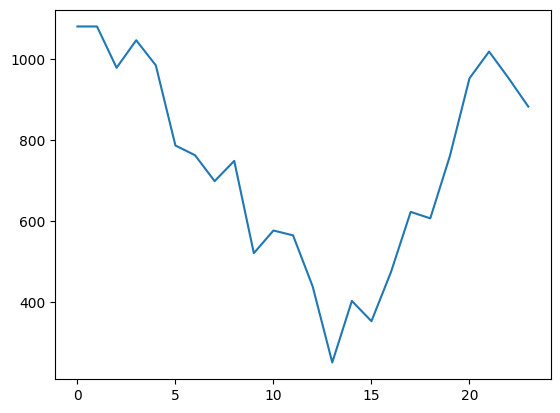

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 1 has size 1

In [19]:
data = np.array(pd.read_csv("./rsfmeasureddata2011.csv")["Building Net (kW)"])


# Split year into 365 day instances or "customers"
all_days = np.array_split(data, 365)
all_days[0][0] = all_days[0][1]


plt.plot(all_days[0])
plt.show()


# Functions to calculate attributes. These are just some examples we could change these.
def max_w(day):
    return np.max(day)


def min_w(day):
    return np.min(day)


def avg_w(day):
    return np.average(day)


def diff_w(day):
    return np.max(day) - np.min(day)


def std(day):
    return np.std(day)


attribute_array = np.empty((0, 5))
for i in range(len(all_days)):
    attribute_array = np.append(
        attribute_array,
        [
            [
                max_w(all_days[i]),
                min_w(all_days[i]),
                avg_w(all_days[i]),
                diff_w(all_days[i]),
                std(all_days[i]),
            ]
        ],
        axis=0,
    )


attribute_array.tofile("PartA.csv", sep=",")

# Part B

In [12]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto")
cluster_array=kmeans.fit_predict(attribute_array)
print(cluster_array)
#I'm not sure how to best visualize this


[1 3 1 1 1 1 3 2 1 1 1 1 3 3 3 3 3 3 3 1 3 3 3 1 1 3 3 3 2 3 1 1 1 1 3 3 3
 3 3 1 1 1 3 3 3 3 3 2 3 3 2 3 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 3 2 2 3 2 2 3 3 2 2 2 2 3 3
 2 2 2 3 2 3 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 0 2 2 2 2 2 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 2 2 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 3 3 3 2 0 0 2 3 0 3 0 0 3 0 3 0 0 0 0 0 0 3 3 0 0 0 3 0 0 0 0 0 0 2 0
 0 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 2 3 0 2 0]


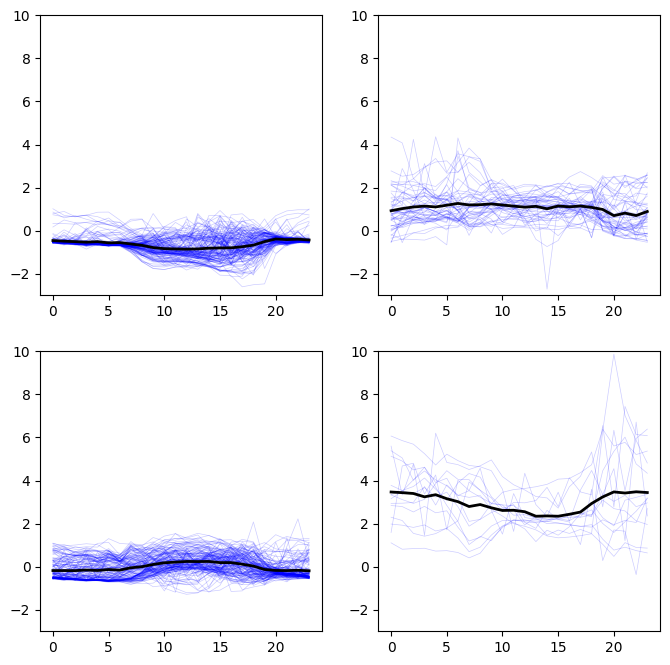

In [13]:
#This isn't actually what we've been asked to do but it might give us a better idea of number of clusters. Uses the whole time series of each day as opposed to the attributes


np_scaled = StandardScaler().fit_transform(all_days)


n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=100, n_init="auto")

df_preds = kmeans.fit_predict(np_scaled)

fig, ax = plt.subplots(int(math.ceil(n_clusters/2)), 2, figsize=(8, 8))
ax = ax.flatten()

avgs=[]
cluster_pop=[]
for idx in np.unique(df_preds):
  indices = np.where(df_preds == idx)[0]

  cluster_pop.append(len(indices))
  np_profs = np_scaled[indices, :].T

  ax[idx].plot(np_profs, color='blue', alpha=0.2, linewidth=0.5)

  ax[idx].plot(np.mean(np_profs, axis=1), color='black', linewidth=2)
  ax[idx].set_ylim(-3, 10)
  avgs.append(np.mean(np_profs, axis=1))

# Part C

In [14]:
x_train=attribute_array[:334,:]
x_test=attribute_array[-31:,:]
y_train=cluster_array[:334]
y_test=cluster_array[-31:]



lr=linear_model.LogisticRegression()
lr.fit(x_train,y_train)


prediction=lr.predict(x_test)
print(prediction)
print(y_test)

print(metrics.accuracy_score(y_test,prediction))


[2 1 3 3 3 1 3 1 1 2 2 1 1 3 3 3 2 2 3 2 3 3 1 3 3 3 2 3 0 2 0]
[3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 2 3 0 2 0]
0.7096774193548387


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
